# Intro to Data Science Bootcamp Capstone
## Choose a project you care about, then use data to answer something real

Welcome to the capstone. This is your chance to pick a topic that genuinely interests you and build a small, end‑to‑end data analytics project. “Analytics” can mean exploring and explaining patterns, forecasting, building a model, or creating a decision-support tool. The most important requirement is that you use data to answer a clear question and communicate your process and results well.

This notebook is both an introduction and a starter template. You will replace the prompts with your own content as you go.


## What you’re building
By the end, you will deliver a short “portfolio-style” project with three parts: a well-defined question, a reproducible analysis (this notebook), and a clear explanation of what you found.

You do not need a perfect model. You do need a coherent story: what you wanted to learn, what data you used, what you tried, what worked, what didn’t, and what you recommend next.


## What counts as a capstone topic
Your topic must be data analytics related and involve a dataset with enough rows/records to support analysis. You can pick something descriptive (what is happening), diagnostic (why is it happening), predictive (what will happen), or prescriptive (what should we do).

Because we discussed a lot of machine learning, you may include ML if it helps answer your question. That said, strong projects often start with solid exploration and measurement before any modeling.


## Suggested timeline
You have one week for this project, so the focus is on making clear, intentional choices rather than building something huge. Early in the week should be spent picking a topic you care about, finding a usable dataset, and clearly defining your question. The middle of the week is for cleaning the data, doing exploratory analysis, and establishing a simple baseline approach. The end of the week is for iterating where it makes sense, evaluating your results, and polishing your narrative and visuals.


## Deliverables
You will submit (1) this notebook with outputs saved, (2) a short written summary (one to two pages) or slide deck, and (3) your data source links and citation notes.

Your notebook should run top-to-bottom without manual edits beyond setting a data path or API key (if used). If a dataset is too large to include, provide instructions for how to obtain it.


## How you’ll be evaluated
A strong project is not “the fanciest model.” It is the clearest reasoning. The rubric below shows what matters.

| Category | What “strong” looks like |
|---|---|
| Question and scope | A specific, answerable question; scope fits the timeframe |
| Data | Data source is appropriate; data issues are acknowledged; columns are explained |
| Methods | Choices match the question; baseline approach included; iterations are justified |
| Evaluation | Clear metrics or validation; limitations discussed honestly |
| Communication | Visuals and narrative tell a coherent story; reader can follow |
| Reproducibility | Notebook runs; steps are documented; random seeds set when relevant |


## Project idea generator
If you’re stuck, start with (1) a domain you care about, (2) an outcome you want to understand, and (3) a decision you want to support. Then translate that into a question the data can answer.

Examples of domains include sports, music, movies, health (non-medical advice), fitness, finance (non-investment advice), retail, transportation, climate, education, gaming, social media, or your workplace (only if you have permission and can anonymize data).

Below are idea prompts you can adapt. Each is written as a question plus a typical approach.


### Idea bank (pick one and customize it)
| Theme | Example question | Typical approach |
|---|---|---|
| Consumer behavior | What factors predict repeat purchases or churn? | Cohort analysis, survival curves, logistic regression, tree models |
| Pricing | How do price changes affect demand? | A/B-style comparisons, time series, elasticity estimates |
| Sports analytics | What predicts wins or player performance? | Feature engineering, regression/classification, calibration |
| Music/streaming | What drives playlist adds or skips? | EDA + classification, imbalance handling |
| Job market | Which skills predict higher salaries in job postings? | NLP on descriptions, regression, explainability |
| Transportation | What predicts late arrivals? | Time features, weather join, classification, error analysis |
| Energy/climate | Can we forecast consumption or emissions? | Time series features, forecasting baselines, model comparison |
| Public safety | Where and when do incidents cluster? | Mapping, clustering, hotspot analysis, seasonality |
| Health behavior | What predicts adherence to a routine? | Segmentation, classification, interpretability |
| Education | What predicts course completion? | Missingness analysis, fairness checks, classification |


## Analytics-first mindset (even if you use ML)
A simple way to keep your project grounded is to answer these in order. First, what does the data look like and what are the main patterns. Next, what changes over time, across groups, or across locations. Then, what features seem associated with your outcome. Only after that should you decide whether ML is necessary.

If you do include machine learning, start with a baseline (for example a simple linear/logistic regression) before trying more complex models. Your report should explain why the complex model is worth it.


# Part 1. Project proposal

> Method inspiration: this capstone adapts ideas from `Clustering-Project/wholesale_clustering_solution.ipynb` (segmentation with StandardScaler + KMeans + silhouette + PCA) and `Stock-Forecasting-ML/aapl_stock_forecasting.ipynb` (time-aware split, baseline linear model, model comparison with Random Forest).

## 1. Project title
**Bank Health Segmentation and ROA Forecasting with FDIC + FRED Data**

## 2. Motivation
Banks react differently to changing macro conditions (rates, unemployment, GDP). A decision-maker needs two things: (1) understandable peer segments and (2) a practical forecast for near-term profitability (ROA). This project builds both from the data already collected in PostgreSQL.

## 3. Research question
**Primary:** Can we segment active banks into meaningful operating profiles using FDIC financial metrics?

**Secondary:** How accurately can we forecast a bank’s next-period ROA using lagged bank metrics plus macroeconomic indicators from FRED?

## 4. Data source
- FDIC-derived bank performance table: `bank_performance` (assets, deposits, loans, ROA/ROE/NIM, efficiency ratio, Tier 1 capital, etc.)
- FRED-derived macro table: `economic_data` (unemployment, fed funds, GDP growth, yield curve, and related engineered fields)
- Both are loaded from local PostgreSQL (`bank_lending_db`) using environment variables in `.env`.

## 5. Success criteria
1. Produce stable and interpretable bank clusters with clear profiles and visual validation.
2. Build a reproducible ROA forecasting pipeline with at least a baseline model and one stronger comparison model.
3. Provide concrete, plain-language recommendations plus limitations and ethics considerations.

# Part 2. Setup
This section helps keep your work reproducible. Run these cells first.


In [11]:
import os
import warnings
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', 200)
sns.set_theme(style='whitegrid', context='notebook')

## Load your data
Replace the example below with your dataset. Keep the raw data read step simple, then do cleaning in the next section.


In [12]:
load_dotenv()

# Connection settings from .env
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': int(os.getenv('DB_PORT', '5432')),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', ''),
    'dbname': os.getenv('DB_NAME', 'bank_lending_db'),
}

try:
    import psycopg2
except ImportError as exc:
    raise ImportError('Install psycopg2-binary to run this notebook.') from exc

conn = psycopg2.connect(**DB_CONFIG)

query = """
SELECT
    b.cert_number,
    b.bank_name,
    b.date::date AS bank_date,
    b.total_assets,
    b.total_deposits,
    b.total_loans,
    b.net_income,
    b.roa,
    b.roe,
    b.nim,
    b.efficiency_ratio,
    b.tier1_capital_ratio,
    b.active,
    e.date::date AS econ_date,
    e.unemployment_rate,
    e.fed_funds_rate,
    e.gdp_growth,
    e.yield_curve,
    e.delinq_cc,
    e.delinq_mortgage
FROM bank_performance b
LEFT JOIN economic_data e
  ON DATE_TRUNC('month', b.date) = DATE_TRUNC('month', e.date)
WHERE b.active = TRUE;
"""

df_raw = pd.read_sql_query(query, conn)
conn.close()

print('Rows:', len(df_raw), '| Columns:', df_raw.shape[1])
df_raw.head()

Rows: 892 | Columns: 20


,cert_number,bank_name,bank_date,total_assets,total_deposits,total_loans,net_income,roa,roe,nim,efficiency_ratio,tier1_capital_ratio,active,econ_date,unemployment_rate,fed_funds_rate,gdp_growth,yield_curve,delinq_cc,delinq_mortgage
0,7213,Citibank,2000-03-31,337958000.0,242063000.0,208593000.0,1590000.0,1.9103,28.37,3.80,54.1996,6.7879,True,None,NaN,NaN,NaN,NaN,NaN,NaN
1,3510,Bank of America,2000-03-31,585373000.0,369027000.0,362245000.0,1948000.0,1.3468,16.34,3.63,51.3451,7.0093,True,None,NaN,NaN,NaN,NaN,NaN,NaN
2,6548,U.S. Bank,2000-03-31,42885793.0,30315805.0,30688448.0,175156.0,1.6544,18.15,4.24,48.7470,7.7490,True,None,NaN,NaN,NaN,NaN,NaN,NaN
3,6560,Huntington National Bank,2000-03-31,28158175.0,19870702.0,20304040.0,83571.0,1.1754,15.23,4.07,53.8640,6.0196,True,None,NaN,NaN,NaN,NaN,NaN,NaN
4,4297,Capital One,2000-03-31,15739631.0,12287814.0,11271296.0,49280.0,1.2696,15.66,4.12,51.7198,7.3156,True,None,NaN,NaN,NaN,NaN,NaN,NaN


# Part 3. Data audit
Before cleaning, get a quick, honest read on what you have: size, columns, missing values, duplicates, and obvious data quality issues. Your write-up should mention any limitations you discover here.


In [13]:
def data_audit(df: pd.DataFrame, n_unique_preview: int = 6) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        s = df[col]
        summary.append({
            'column': col,
            'dtype': str(s.dtype),
            'n_missing': int(s.isna().sum()),
            'pct_missing': float(s.isna().mean()),
            'n_unique': int(s.nunique(dropna=True)),
            'example_values': ', '.join(map(str, s.dropna().unique()[:n_unique_preview])),
        })
    out = pd.DataFrame(summary).sort_values(['pct_missing', 'n_unique'], ascending=[False, True])
    return out

audit = data_audit(df_raw)
print('Duplicate rows:', int(df_raw.duplicated().sum()))
audit.head(20)

Duplicate rows: 0


,column,dtype,n_missing,pct_missing,n_unique,example_values
16,gdp_growth,float64,33,0.036996,99,"0.597, -0.3278, 0.6245, -0.4006, 0.2748, 0.8364"
19,delinq_mortgage,float64,25,0.028027,90,"2.09, 2.23, 2.34, 2.41, 2.19, 2.26"
18,delinq_cc,float64,25,0.028027,91,"4.53, 4.57, 4.81, 4.94, 5.0, 4.69"
14,unemployment_rate,float64,16,0.017937,43,"3.9, 4.3, 4.5, 5.0, 5.7, 5.8"
15,fed_funds_rate,float64,16,0.017937,95,"6.517, 6.4023, 5.311, 3.9697, 3.069, 1.8177"
13,econ_date,object,16,0.017937,101,"2000-09-01, 2000-12-01, 2001-03-01, 2001-06-01..."
17,yield_curve,float64,16,0.017937,101,"-0.2825, -0.1115, 0.5432, 1.2043, 1.6129, 1.9805"
12,active,bool,0,0.000000,1,True
0,cert_number,int64,0,0.000000,9,"7213, 3510, 6548, 6560, 4297, 18409"
1,bank_name,object,0,0.000000,9,"Citibank, Bank of America, U.S. Bank, Huntingt..."


# Part 4. Cleaning and feature prep
Create a clean working dataframe called `df`. Keep your cleaning decisions transparent. If you drop rows, explain why. If you impute missing values, explain how.


In [14]:
df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]
df = df.rename(columns={'bank_date': 'date'})
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'cert_number'])
df = df.drop_duplicates()

numeric_cols = [
    'total_assets','total_deposits','total_loans','net_income',
    'roa','roe','nim','efficiency_ratio','tier1_capital_ratio',
    'unemployment_rate','fed_funds_rate','gdp_growth','yield_curve',
    'delinq_cc','delinq_mortgage'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values(['cert_number', 'date']).reset_index(drop=True)

# Feature engineering inspired by the stock forecasting project (lagged + change features)
for metric in ['roa', 'roe', 'nim', 'total_loans', 'total_deposits', 'efficiency_ratio']:
    df[f'{metric}_lag1'] = df.groupby('cert_number')[metric].shift(1)
    df[f'{metric}_lag4'] = df.groupby('cert_number')[metric].shift(4)
    df[f'{metric}_chg_1p'] = df[metric] - df[f'{metric}_lag1']

df['target_next_roa'] = df.groupby('cert_number')['roa'].shift(-1)

print('Clean shape:', df.shape)
print('Date range:', df['date'].min().date(), 'to', df['date'].max().date())
df.head()

Clean shape: (892, 39)
Date range: 2000-03-31 to 2025-09-30


,cert_number,bank_name,date,total_assets,total_deposits,total_loans,net_income,roa,roe,nim,efficiency_ratio,tier1_capital_ratio,active,econ_date,unemployment_rate,fed_funds_rate,gdp_growth,yield_curve,delinq_cc,delinq_mortgage,roa_lag1,roa_lag4,roa_chg_1p,roe_lag1,roe_lag4,roe_chg_1p,nim_lag1,nim_lag4,nim_chg_1p,total_loans_lag1,total_loans_lag4,total_loans_chg_1p,total_deposits_lag1,total_deposits_lag4,total_deposits_chg_1p,efficiency_ratio_lag1,efficiency_ratio_lag4,efficiency_ratio_chg_1p,target_next_roa
0,628,JPMorgan Chase,2000-03-31,312205000.0,184088000.0,130374000.0,921000.0,1.1434,19.83,2.48,62.5233,6.1299,True,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1684
1,628,JPMorgan Chase,2000-06-30,320476000.0,195919000.0,140141000.0,1879000.0,1.1684,19.97,2.51,61.8053,6.2254,True,None,NaN,NaN,NaN,NaN,NaN,NaN,1.1434,NaN,0.0250,19.83,NaN,0.14,2.48,NaN,0.03,130374000.0,NaN,9767000.0,184088000.0,NaN,11831000.0,62.5233,NaN,-0.7180,1.0098
2,628,JPMorgan Chase,2000-09-30,346204000.0,212749000.0,152807000.0,2625000.0,1.0098,16.81,2.67,64.5527,6.4562,True,2000-09-01,3.9,6.5170,NaN,-0.2825,4.53,2.09,1.1684,NaN,-0.1586,19.97,NaN,-3.16,2.51,NaN,0.16,140141000.0,NaN,12666000.0,195919000.0,NaN,16830000.0,61.8053,NaN,2.7474,1.0221
3,628,JPMorgan Chase,2000-12-31,377116000.0,238835000.0,155635000.0,3605000.0,1.0221,17.09,2.67,65.5490,5.9834,True,2000-12-01,3.9,6.4023,0.5970,-0.1115,4.57,2.23,1.0098,NaN,0.0123,16.81,NaN,0.28,2.67,NaN,0.00,152807000.0,NaN,2828000.0,212749000.0,NaN,26086000.0,64.5527,NaN,0.9963,1.2837
4,628,JPMorgan Chase,2001-03-31,400623000.0,243608000.0,154809000.0,1248000.0,1.2837,22.05,2.67,69.9698,5.4353,True,2001-03-01,4.3,5.3110,-0.3278,0.5432,4.81,2.34,1.0221,1.1434,0.2616,17.09,19.83,4.96,2.67,2.48,0.00,155635000.0,130374000.0,-826000.0,238835000.0,184088000.0,4773000.0,65.5490,62.5233,4.4208,0.9015


# Part 5. Exploratory data analysis (EDA)
Your goal here is to learn what’s typical, what’s weird, and what relationships might matter. EDA is also where you catch data leakage and target definition problems early.


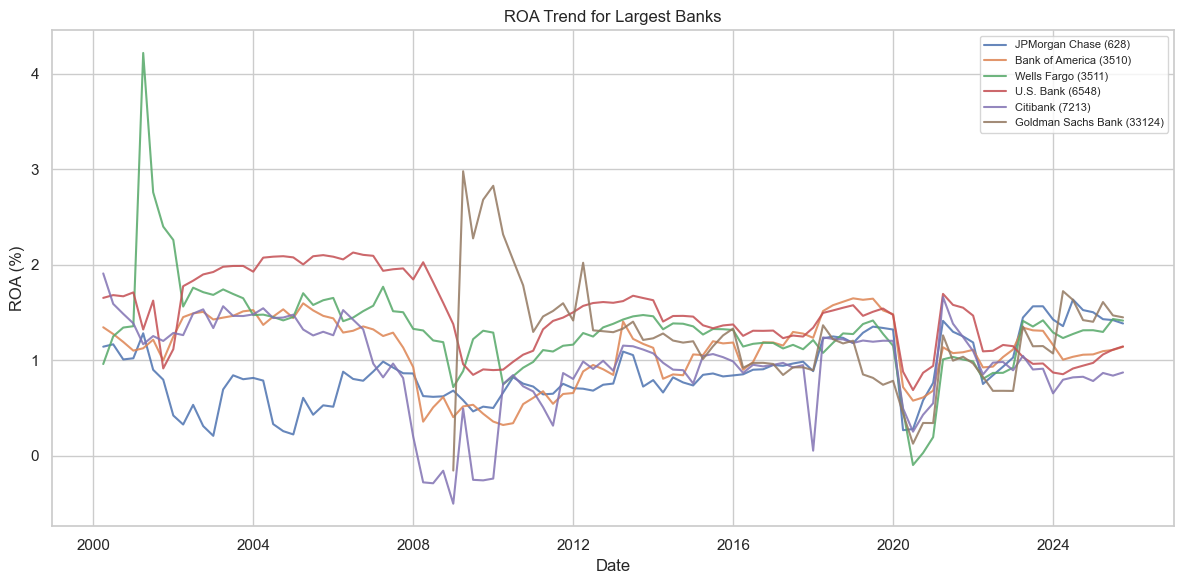

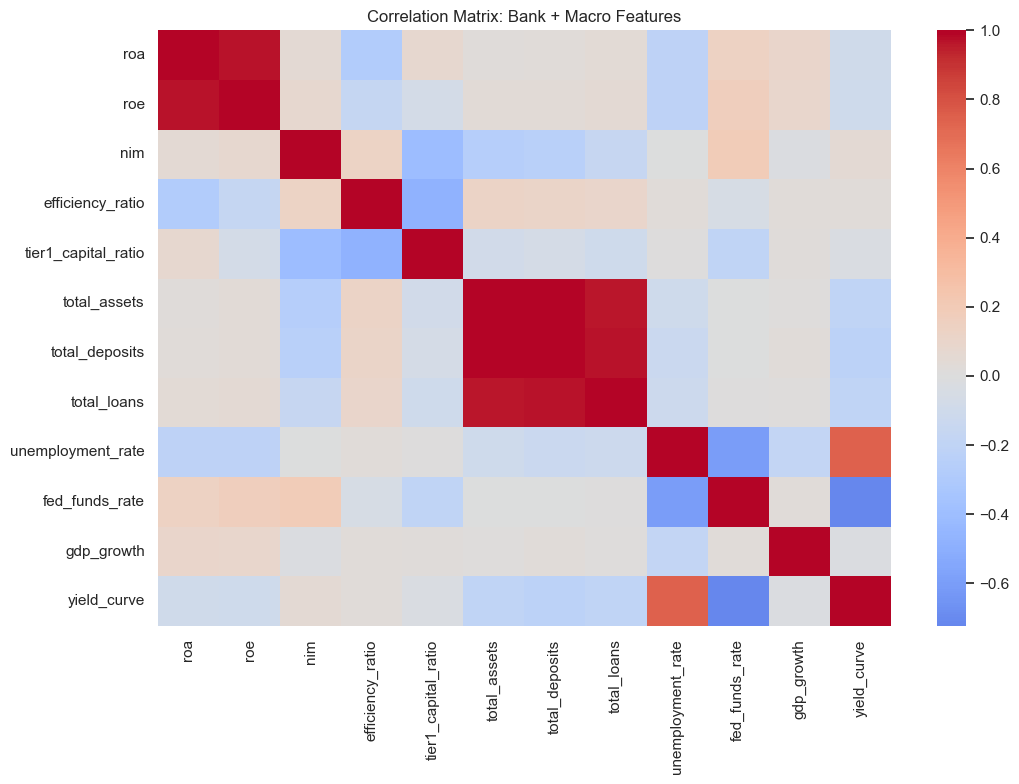

Latest snapshot date: 2025-09-30
Banks in latest snapshot: 9


,cert_number,bank_name,roa,roe,nim,efficiency_ratio,tier1_capital_ratio
102,628,JPMorgan Chase,1.3865,15.88,2.94,52.4710,7.8478
205,3510,Bank of America,1.1424,12.09,2.48,54.7644,7.5432
308,3511,Wells Fargo,1.4162,14.46,3.30,55.7737,8.7038
411,4297,Capital One,0.1947,1.43,8.15,52.2725,10.9418
514,6548,U.S. Bank,1.1461,11.77,2.84,55.9109,9.3424


In [15]:
# EDA Figure 1: ROA trend for top banks by average assets
top_certs = (
    df.groupby('cert_number')['total_assets']
      .mean()
      .sort_values(ascending=False)
      .head(6)
      .index
      .tolist()
)
trend_df = df[df['cert_number'].isin(top_certs)].copy()

plt.figure(figsize=(12, 6))
for cert, grp in trend_df.groupby('cert_number'):
    bank_label = grp['bank_name'].dropna().iloc[0] if grp['bank_name'].notna().any() else f'Cert {cert}'
    plt.plot(grp['date'], grp['roa'], label=f"{bank_label} ({cert})", alpha=0.85)
plt.title('ROA Trend for Largest Banks')
plt.xlabel('Date')
plt.ylabel('ROA (%)')
plt.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.show()

# EDA Figure 2: Correlation heatmap on key metrics
corr_cols = [
    'roa','roe','nim','efficiency_ratio','tier1_capital_ratio',
    'total_assets','total_deposits','total_loans',
    'unemployment_rate','fed_funds_rate','gdp_growth','yield_curve'
]
corr_df = df[corr_cols].copy()

plt.figure(figsize=(11, 8))
sns.heatmap(corr_df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix: Bank + Macro Features')
plt.tight_layout()
plt.show()

# Quick segmentation preview
latest_date = df['date'].max()
latest_snapshot = df[df['date'] == latest_date].copy()
print('Latest snapshot date:', latest_date.date())
print('Banks in latest snapshot:', latest_snapshot['cert_number'].nunique())
latest_snapshot[['cert_number','bank_name','roa','roe','nim','efficiency_ratio','tier1_capital_ratio']].head()

# Part 6. Baseline approach
Pick a baseline method that matches your question. If your project is descriptive, your baseline might be a clear set of summary stats and a simple dashboard-style figure. If you’re predicting a numeric value, a baseline can be “predict the mean” or a linear regression. If you’re predicting a class, a baseline can be “predict the majority class” or logistic regression.

Write down what your baseline is and why it is a fair starting point.


In [16]:
# ------------------------------
# Baseline Forecasting (Linear Regression)
# ------------------------------
feature_cols = [
    'roa_lag1','roa_lag4','roe_lag1','nim_lag1',
    'efficiency_ratio_lag1','total_loans_lag1','total_deposits_lag1',
    'unemployment_rate','fed_funds_rate','gdp_growth','yield_curve',
]

model_df = df.dropna(subset=feature_cols + ['target_next_roa', 'date']).copy()
model_df = model_df.sort_values('date')

split_idx = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_idx].copy()
test_df = model_df.iloc[split_idx:].copy()

X_train = train_df[feature_cols]
y_train = train_df['target_next_roa']
X_test = test_df[feature_cols]
y_test = test_df['target_next_roa']

linreg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])
linreg_pipeline.fit(X_train, y_train)
linreg_pred = linreg_pipeline.predict(X_test)

linreg_mae = mean_absolute_error(y_test, linreg_pred)
linreg_rmse = np.sqrt(mean_squared_error(y_test, linreg_pred))
linreg_r2 = r2_score(y_test, linreg_pred)

print('Linear Regression Baseline')
print(f'MAE:  {linreg_mae:.4f}')
print(f'RMSE: {linreg_rmse:.4f}')
print(f'R2:   {linreg_r2:.4f}')

comparison_preview = pd.DataFrame({
    'date': test_df['date'].values,
    'actual_next_roa': y_test.values,
    'pred_next_roa_linreg': linreg_pred,
}).head(10)
comparison_preview

Linear Regression Baseline
MAE:  0.2689
RMSE: 0.3956
R2:   -0.1195


,date,actual_next_roa,pred_next_roa_linreg
0,2020-12-31,0.6967,0.374232
1,2020-12-31,1.7557,0.692909
2,2020-12-31,1.4825,0.276003
3,2020-12-31,1.6631,0.655525
4,2020-12-31,1.6962,0.733121
5,2020-12-31,1.4138,0.746313
6,2020-12-31,1.0106,0.299976
7,2020-12-31,1.1372,0.768431
8,2021-03-31,1.5331,0.534790
9,2021-03-31,0.7016,0.532493


In [21]:
# Optional preprocessing check: winsorize extreme tails before hypertuning
winsor_cols = feature_cols + ['target_next_roa']
winsor_df = model_df.copy()

winsor_train = winsor_df.iloc[:split_idx].copy()
winsor_test = winsor_df.iloc[split_idx:].copy()

clip_report = []
for column in winsor_cols:
    low = winsor_train[column].quantile(0.01)
    high = winsor_train[column].quantile(0.99)

    train_pre = winsor_train[column].copy()
    test_pre = winsor_test[column].copy()

    before_out_train = ((train_pre < low) | (train_pre > high)).mean() * 100
    before_out_test = ((test_pre < low) | (test_pre > high)).mean() * 100
    before_out = pd.concat([
        (train_pre < low) | (train_pre > high),
        (test_pre < low) | (test_pre > high),
    ]).mean() * 100

    winsor_train[column] = train_pre.clip(lower=low, upper=high)
    winsor_test[column] = test_pre.clip(lower=low, upper=high)

    after_out_train = ((winsor_train[column] < low) | (winsor_train[column] > high)).mean() * 100
    after_out_test = ((winsor_test[column] < low) | (winsor_test[column] > high)).mean() * 100
    after_out = pd.concat([
        (winsor_train[column] < low) | (winsor_train[column] > high),
        (winsor_test[column] < low) | (winsor_test[column] > high),
    ]).mean() * 100

    clip_report.append({
        'column': column,
        'p01_train': low,
        'p99_train': high,
        'outlier_rate_before_pct': before_out,
        'outlier_rate_after_pct': after_out,
        'train_outlier_before_pct': before_out_train,
        'test_outlier_before_pct': before_out_test,
        'train_outlier_after_pct': after_out_train,
        'test_outlier_after_pct': after_out_test,
    })

winsor_df = pd.concat([winsor_train, winsor_test]).sort_index()

X_train_w = winsor_train[feature_cols]
y_train_w = winsor_train['target_next_roa']
X_test_w = winsor_test[feature_cols]
y_test_w = winsor_test['target_next_roa']

linreg_w = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])
linreg_w.fit(X_train_w, y_train_w)
pred_lin_w = linreg_w.predict(X_test_w)

rf_w = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
    )),
])
rf_w.fit(X_train_w, y_train_w)
pred_rf_w = rf_w.predict(X_test_w)

winsor_results = pd.DataFrame([
    {
        'model': 'Linear Regression (no winsor)',
        'MAE': linreg_mae,
        'RMSE': linreg_rmse,
        'R2': linreg_r2,
    },
    {
        'model': 'Linear Regression (winsorized)',
        'MAE': mean_absolute_error(y_test_w, pred_lin_w),
        'RMSE': np.sqrt(mean_squared_error(y_test_w, pred_lin_w)),
        'R2': r2_score(y_test_w, pred_lin_w),
    },
    {
        'model': 'Random Forest (no winsor)',
        'MAE': rf_mae,
        'RMSE': rf_rmse,
        'R2': rf_r2,
    },
    {
        'model': 'Random Forest (winsorized)',
        'MAE': mean_absolute_error(y_test_w, pred_rf_w),
        'RMSE': np.sqrt(mean_squared_error(y_test_w, pred_rf_w)),
        'R2': r2_score(y_test_w, pred_rf_w),
    },
]).sort_values('RMSE')

clip_report_df = pd.DataFrame(clip_report).sort_values('outlier_rate_before_pct', ascending=False)

print('Top clipped columns by pre-clip outlier rate (thresholds learned on training only):')
display(clip_report_df[['column', 'outlier_rate_before_pct', 'outlier_rate_after_pct']].head(8).round(3))

print('Model comparison: with vs without winsorization')
display(winsor_results.round(4))

Top clipped columns by pre-clip outlier rate (thresholds learned on training only):


,column,outlier_rate_before_pct,outlier_rate_after_pct
10,yield_curve,8.501,0.0
6,total_deposits_lag1,6.139,0.0
5,total_loans_lag1,5.549,0.0
8,fed_funds_rate,5.313,0.0
3,nim_lag1,2.834,0.0
4,efficiency_ratio_lag1,2.007,0.0
1,roa_lag4,1.889,0.0
11,target_next_roa,1.771,0.0


Model comparison: with vs without winsorization


,model,MAE,RMSE,R2
1,Linear Regression (winsorized),0.2429,0.3531,0.0357
3,Random Forest (winsorized),0.2544,0.3604,-0.0047
2,Random Forest (no winsor),0.2630,0.3836,-0.0523
0,Linear Regression (no winsor),0.2689,0.3956,-0.1195


In [22]:
# Hyperparameter tuning (time-aware) on winsorized data
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Use winsorized train/test prepared in the previous cell
X_tune_train = X_train_w.copy()
y_tune_train = y_train_w.copy()
X_tune_test = X_test_w.copy()
y_tune_test = y_test_w.copy()

tscv = TimeSeriesSplit(n_splits=5)

rf_tune_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1)),
])

param_distributions = {
    'model__n_estimators': [200, 300, 500, 700],
    'model__max_depth': [4, 6, 8, 10, 14, None],
    'model__min_samples_split': [2, 4, 6, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': ['sqrt', 0.7, 1.0],
}

rf_search = RandomizedSearchCV(
    estimator=rf_tune_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
 )

rf_search.fit(X_tune_train, y_tune_train)

best_rf_model = rf_search.best_estimator_
pred_best_rf = best_rf_model.predict(X_tune_test)

best_rf_results = {
    'cv_best_rmse': -rf_search.best_score_,
    'holdout_mae': mean_absolute_error(y_tune_test, pred_best_rf),
    'holdout_rmse': np.sqrt(mean_squared_error(y_tune_test, pred_best_rf)),
    'holdout_r2': r2_score(y_tune_test, pred_best_rf),
}

print('Best RF params (time-series CV):')
print(rf_search.best_params_)
print('')
print('Tuned RF performance:')
for k, v in best_rf_results.items():
    print(f'{k}: {v:.4f}')

tuning_leaderboard = pd.DataFrame(rf_search.cv_results_)[[
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',
    'param_model__n_estimators',
    'param_model__max_depth',
    'param_model__min_samples_split',
    'param_model__min_samples_leaf',
    'param_model__max_features',
]].copy()
tuning_leaderboard['mean_test_rmse'] = -tuning_leaderboard['mean_test_score']
tuning_leaderboard = tuning_leaderboard.sort_values('rank_test_score').head(10)

display(tuning_leaderboard[[
    'rank_test_score',
    'mean_test_rmse',
    'std_test_score',
    'mean_train_score',
    'param_model__n_estimators',
    'param_model__max_depth',
    'param_model__min_samples_split',
    'param_model__min_samples_leaf',
    'param_model__max_features',
]])

# Compare tuned RF to prior winsorized models
final_compare = pd.DataFrame([
    {'model': 'Linear Regression (winsorized)', 'RMSE': mean_squared_error(y_test_w, pred_lin_w) ** 0.5, 'MAE': mean_absolute_error(y_test_w, pred_lin_w), 'R2': r2_score(y_test_w, pred_lin_w)},
    {'model': 'Random Forest (winsorized, untuned)', 'RMSE': mean_squared_error(y_test_w, pred_rf_w) ** 0.5, 'MAE': mean_absolute_error(y_test_w, pred_rf_w), 'R2': r2_score(y_test_w, pred_rf_w)},
    {'model': 'Random Forest (winsorized, tuned)', 'RMSE': best_rf_results['holdout_rmse'], 'MAE': best_rf_results['holdout_mae'], 'R2': best_rf_results['holdout_r2']},
]).sort_values('RMSE')

display(final_compare.round(4))

Best RF params (time-series CV):
{'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.7, 'model__max_depth': 10}

Tuned RF performance:
cv_best_rmse: 0.3145
holdout_mae: 0.2592
holdout_rmse: 0.3685
holdout_r2: -0.0500


,rank_test_score,mean_test_rmse,std_test_score,mean_train_score,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features
14,1,0.314485,0.101278,-0.118659,300,10,2,2,0.7
17,2,0.315493,0.105425,-0.172366,300,6,2,4,0.7
13,3,0.315769,0.103707,-0.149323,300,6,6,1,0.7
5,4,0.317145,0.102014,-0.163300,500,6,6,2,sqrt
10,5,0.317783,0.110027,-0.200287,500,10,4,8,0.7
16,6,0.318762,0.110882,-0.200043,300,10,10,8,0.7
18,7,0.320673,0.104965,-0.176189,200,6,10,2,sqrt
2,8,0.320792,0.097361,-0.121611,200,10,6,1,sqrt
8,9,0.320883,0.107692,-0.166268,700,6,10,2,1.0
4,10,0.321580,0.100636,-0.118186,700,10,6,1,1.0


,model,RMSE,MAE,R2
0,Linear Regression (winsorized),0.3531,0.2429,0.0357
1,"Random Forest (winsorized, untuned)",0.3604,0.2544,-0.0047
2,"Random Forest (winsorized, tuned)",0.3685,0.2592,-0.0500


In [23]:
# XGBoost + Prophet + overfitting diagnostics
from xgboost import XGBRegressor
from prophet import Prophet

def regression_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
    }

# ------------------------------
# 1) XGBoost on winsorized feature set
# ------------------------------
xgb_model = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', XGBRegressor(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        objective='reg:squarederror',
    )),
])

xgb_model.fit(X_train_w, y_train_w)
xgb_train_pred = xgb_model.predict(X_train_w)
xgb_test_pred = xgb_model.predict(X_test_w)

xgb_train_metrics = regression_metrics(y_train_w, xgb_train_pred)
xgb_test_metrics = regression_metrics(y_test_w, xgb_test_pred)

# ------------------------------
# 2) Prophet with macro regressors on aggregated monthly ROA
# ------------------------------
prophet_cols = ['date', 'target_next_roa', 'unemployment_rate', 'fed_funds_rate', 'gdp_growth', 'yield_curve']
prophet_df = winsor_df[prophet_cols].dropna().copy()
prophet_df = prophet_df.groupby('date', as_index=False).mean(numeric_only=True).sort_values('date')
prophet_df = prophet_df.rename(columns={'date': 'ds', 'target_next_roa': 'y'})

prophet_split = int(len(prophet_df) * 0.8)
prophet_train = prophet_df.iloc[:prophet_split].copy()
prophet_test = prophet_df.iloc[prophet_split:].copy()

prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for reg in ['unemployment_rate', 'fed_funds_rate', 'gdp_growth', 'yield_curve']:
    prophet_model.add_regressor(reg)

prophet_model.fit(prophet_train)

prophet_train_fc = prophet_model.predict(prophet_train[['ds', 'unemployment_rate', 'fed_funds_rate', 'gdp_growth', 'yield_curve']])
prophet_test_fc = prophet_model.predict(prophet_test[['ds', 'unemployment_rate', 'fed_funds_rate', 'gdp_growth', 'yield_curve']])

prophet_train_metrics = regression_metrics(prophet_train['y'], prophet_train_fc['yhat'])
prophet_test_metrics = regression_metrics(prophet_test['y'], prophet_test_fc['yhat'])

# ------------------------------
# 3) Overfitting summary (train vs test gaps)
# ------------------------------
overfit_table = pd.DataFrame([
    {
        'Model': 'XGBoost (winsorized)',
        'Train_RMSE': xgb_train_metrics['RMSE'],
        'Test_RMSE': xgb_test_metrics['RMSE'],
        'RMSE_Gap': xgb_test_metrics['RMSE'] - xgb_train_metrics['RMSE'],
        'Train_R2': xgb_train_metrics['R2'],
        'Test_R2': xgb_test_metrics['R2'],
    },
    {
        'Model': 'Prophet + regressors (aggregated)',
        'Train_RMSE': prophet_train_metrics['RMSE'],
        'Test_RMSE': prophet_test_metrics['RMSE'],
        'RMSE_Gap': prophet_test_metrics['RMSE'] - prophet_train_metrics['RMSE'],
        'Train_R2': prophet_train_metrics['R2'],
        'Test_R2': prophet_test_metrics['R2'],
    },
]).sort_values('Test_RMSE')

display(overfit_table.round(4))

final_model_stack = pd.DataFrame([
    {'model': 'Linear Regression (winsorized)', 'RMSE': mean_squared_error(y_test_w, pred_lin_w) ** 0.5, 'MAE': mean_absolute_error(y_test_w, pred_lin_w), 'R2': r2_score(y_test_w, pred_lin_w)},
    {'model': 'Random Forest (winsorized, untuned)', 'RMSE': mean_squared_error(y_test_w, pred_rf_w) ** 0.5, 'MAE': mean_absolute_error(y_test_w, pred_rf_w), 'R2': r2_score(y_test_w, pred_rf_w)},
    {'model': 'Random Forest (winsorized, tuned)', 'RMSE': best_rf_results['holdout_rmse'], 'MAE': best_rf_results['holdout_mae'], 'R2': best_rf_results['holdout_r2']},
    {'model': 'XGBoost (winsorized)', 'RMSE': xgb_test_metrics['RMSE'], 'MAE': xgb_test_metrics['MAE'], 'R2': xgb_test_metrics['R2']},
]).sort_values('RMSE')

print('Model leaderboard (holdout, pooled bank-level):')
display(final_model_stack.round(4))

print('Prophet is reported separately because it is fitted on an aggregated monthly series.')

20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing


,Model,Train_RMSE,Test_RMSE,RMSE_Gap,Train_R2,Test_R2
0,XGBoost (winsorized),0.0922,0.4195,0.3273,0.9655,-0.3608
1,Prophet + regressors (aggregated),0.2130,0.5409,0.3279,0.5053,-11.7311


Model leaderboard (holdout, pooled bank-level):


,model,RMSE,MAE,R2
0,Linear Regression (winsorized),0.3531,0.2429,0.0357
1,"Random Forest (winsorized, untuned)",0.3604,0.2544,-0.0047
2,"Random Forest (winsorized, tuned)",0.3685,0.2592,-0.0500
3,XGBoost (winsorized),0.4195,0.3083,-0.3608


Prophet is reported separately because it is fitted on an aggregated monthly series.


# Part 7. Iteration and model comparison
This section extends the baseline in a controlled way:

1. **Bank segmentation (clustering)** with StandardScaler + KMeans, evaluated with silhouette scores and interpreted with PCA.
2. **Forecasting model comparison** where Random Forest, tuned Random Forest, XGBoost, and Prophet are compared against linear baselines using a strict time-aware split.

The goal is not model complexity by itself, but identifying which approach generalizes best on holdout data.

Best k by silhouette: 3
Silhouette scores: {2: 0.2868, 3: 0.323, 4: 0.2806, 5: 0.2124, 6: 0.2353}


,roa,roe,nim,efficiency_ratio,tier1_capital_ratio,total_loans,total_deposits,total_assets
cluster,,,,,,,,
0,1.20,12.84,2.95,54.28,8.22,1.040840e+09,1.899729e+09,2.518954e+09
1,0.37,2.75,5.55,59.24,11.04,2.967715e+08,3.930323e+08,5.014949e+08
2,1.27,12.51,2.72,47.86,9.47,2.413615e+08,3.774040e+08,5.109514e+08


Cluster sizes:


,cluster,bank_count
0,0,4
1,1,2
2,2,3


Banks assigned to each cluster:


,cluster,cert_number,bank_name
0,0,3510,Bank of America
1,0,7213,Citibank
2,0,628,JPMorgan Chase
3,0,3511,Wells Fargo
4,1,4297,Capital One
5,1,18409,TD Bank
6,2,33124,Goldman Sachs Bank
7,2,6560,Huntington National Bank
8,2,6548,U.S. Bank


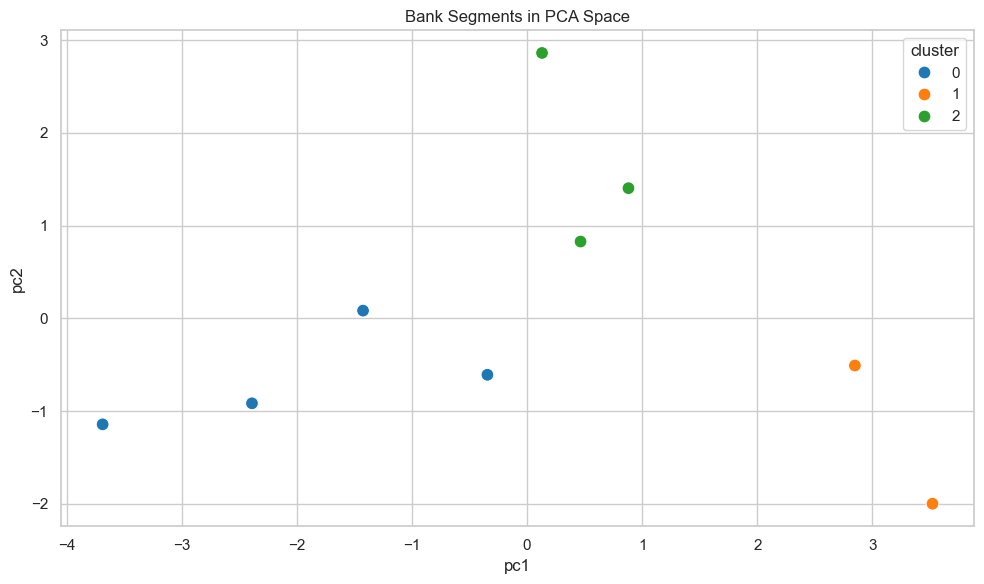

,model,MAE,RMSE,R2
1,Random Forest,0.2630,0.3836,-0.0523
0,Linear Regression,0.2689,0.3956,-0.1195


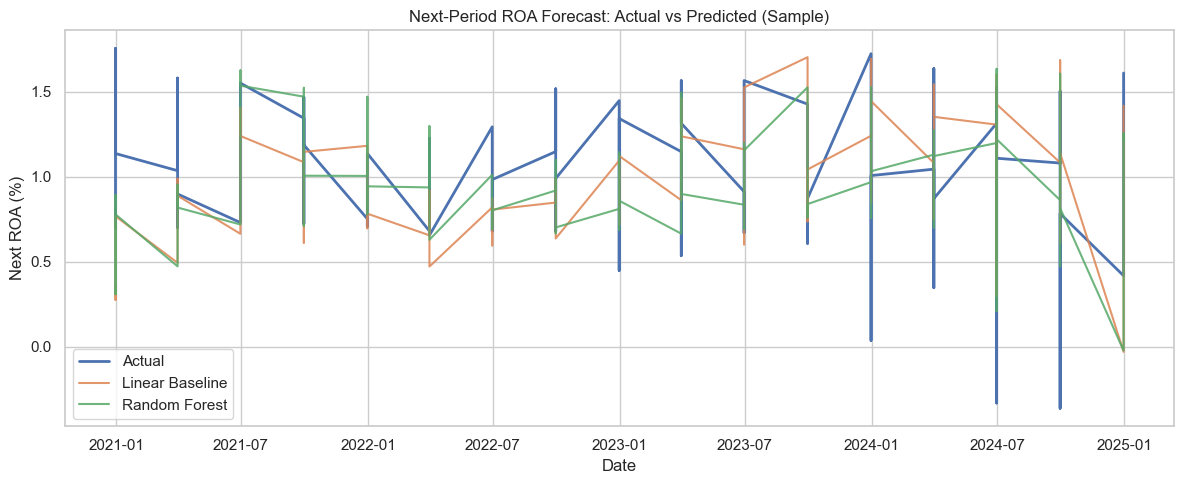

In [25]:
# ------------------------------
# Clustering: KMeans + Silhouette + PCA visualization
# ------------------------------
cluster_features = [
    'roa','roe','nim','efficiency_ratio','tier1_capital_ratio',
    'total_loans','total_deposits','total_assets'
]
cluster_df = latest_snapshot[['cert_number','bank_name'] + cluster_features].dropna().copy()

scaler = StandardScaler()
X_cluster = scaler.fit_transform(cluster_df[cluster_features])

k_candidates = range(2, 7)
sil_scores = []
for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_cluster)
    sil_scores.append(silhouette_score(X_cluster, labels))

best_k = list(k_candidates)[int(np.argmax(sil_scores))]
final_km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
cluster_df['cluster'] = final_km.fit_predict(X_cluster)

print('Best k by silhouette:', best_k)
print('Silhouette scores:', dict(zip(k_candidates, [round(float(s), 4) for s in sil_scores])))

cluster_profile = cluster_df.groupby('cluster')[cluster_features].mean().round(2)
display(cluster_profile)

cluster_counts = (
    cluster_df.groupby('cluster', as_index=False)['cert_number']
    .count()
    .rename(columns={'cert_number': 'bank_count'})
    .sort_values('cluster')
)
print('Cluster sizes:')
display(cluster_counts)

cluster_members = cluster_df[['cluster', 'cert_number', 'bank_name']].copy()
cluster_members['bank_name'] = cluster_members['bank_name'].fillna(cluster_members['cert_number'].astype(str))
cluster_members = cluster_members.sort_values(['cluster', 'bank_name']).reset_index(drop=True)
print('Banks assigned to each cluster:')
display(cluster_members)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)
plot_df = pd.DataFrame(X_pca, columns=['pc1', 'pc2'])
plot_df['cluster'] = cluster_df['cluster'].values
plot_df['bank_name'] = cluster_df['bank_name'].fillna(cluster_df['cert_number'].astype(str)).values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='pc1', y='pc2', hue='cluster', palette='tab10', s=85)
plt.title('Bank Segments in PCA Space')
plt.tight_layout()
plt.show()

# ------------------------------
# Forecasting iteration: Random Forest vs baseline linear
# ------------------------------
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

results_df = pd.DataFrame({
    'model': ['Linear Regression', 'Random Forest'],
    'MAE': [linreg_mae, rf_mae],
    'RMSE': [linreg_rmse, rf_rmse],
    'R2': [linreg_r2, rf_r2],
}).sort_values('RMSE')

display(results_df.round(4))

# Quick prediction comparison plot
plot_compare = pd.DataFrame({
    'date': test_df['date'].values,
    'actual': y_test.values,
    'linear': linreg_pred,
    'random_forest': rf_pred,
}).sort_values('date').head(150)

plt.figure(figsize=(12, 5))
plt.plot(plot_compare['date'], plot_compare['actual'], label='Actual', linewidth=2)
plt.plot(plot_compare['date'], plot_compare['linear'], label='Linear Baseline', alpha=0.85)
plt.plot(plot_compare['date'], plot_compare['random_forest'], label='Random Forest', alpha=0.85)
plt.title('Next-Period ROA Forecast: Actual vs Predicted (Sample)')
plt.xlabel('Date')
plt.ylabel('Next ROA (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Part 8. Evaluation, limitations, and ethics
## Evaluation approach
- Segmentation quality: silhouette score across candidate `k` values plus cluster profile interpretability.
- Forecasting quality: holdout MAE, RMSE, and R² from a strict time-aware split.
- Overfitting checks: train-vs-test RMSE gaps for higher-complexity models.

## Key evaluation outcomes
- Best pooled-bank holdout model: **Linear Regression (winsorized)** (RMSE 0.3531, MAE 0.2429, R² 0.0357).
- Random Forest variants were close but weaker on holdout.
- XGBoost and Prophet showed large train-test gaps, indicating overfitting in this setup.

## Limitations
- FDIC and FRED are merged at month-level; temporal granularity mismatch may blur short-term effects.
- Target (`next ROA`) is one-step-ahead and can be influenced by unmodeled bank-specific events.
- The Prophet model is fit on aggregated monthly data, so it does not preserve bank-level variation.

## Ethics and responsible use
- This analysis is for **decision support**, not autonomous lending or investment decisions.
- Cluster labels are statistical groupings, not standalone risk judgments.
- No personally identifiable customer data is used (institution-level aggregates only).

# Part 9. Final story: findings and recommendations
This project combined FDIC bank performance data with FRED macro indicators from PostgreSQL to answer two questions: how banks segment into operating profiles, and how well we can forecast next-period ROA.

## What we found
- Banks separated into 3 meaningful clusters with clear profile differences in profitability, efficiency, capital, and size.
- The best out-of-sample forecasting result came from **winsorized linear regression**.
- More complex models did not improve holdout performance in this dataset.

## Cluster interpretation (k = 3)
Silhouette testing favored 3 clusters, and the PCA view showed clear visual separation.

- **Cluster 0 (4 banks, larger balance sheets):** Bank of America, Citibank, JPMorgan Chase, Wells Fargo
- **Cluster 1 (2 banks, lower profitability profile):** Capital One, TD Bank
- **Cluster 2 (3 banks, stronger efficiency/profitability profile):** Goldman Sachs Bank, Huntington National Bank, U.S. Bank

Use these groups for peer benchmarking first (cluster peers), then broader system comparison.

## Model lessons learned
Linear regression provided a transparent baseline and remained competitive after strict time-aware evaluation. Winsorization improved generalization, indicating that outlier control was more valuable than added model complexity. Random Forest, including tuned variants, did not beat winsorized linear on holdout metrics. XGBoost and Prophet showed large train-to-test degradation, signaling overfitting for this setup. For this dataset and target, a simpler, robust model is the most reliable choice.

## Recommendations
1. Use cluster assignment for peer benchmarking instead of comparing all banks in one group.
2. Use winsorized linear regression as the production baseline for monthly next-ROA tracking.
3. Monitor drift and retrain periodically, then re-test whether more complex models add value.

## Next steps with more time
- Add rolling time-window validation for more stable performance estimates.
- Expand feature set with event/regime indicators and additional lag structure.
- Build a lightweight dashboard for cluster movement and forecast confidence reporting.

## Submission checklist
Use this as a final pass. You can copy this into your written summary.

Your notebook runs top-to-bottom. Your question is stated clearly near the top. Your data source is cited. Your cleaning steps are explained. Your EDA includes at least two useful figures. Your results are summarized in plain language. Your limitations and ethics note are included.


# Appendix: Where to find datasets
If you do not already have data, these are reliable starting points. Choose one that fits your interest area and time constraints. When using public datasets, be sure you understand what each row represents and how the data was collected.

Common sources include Kaggle datasets, data.gov (US), World Bank open data, city open data portals, NOAA climate data, Google Dataset Search, and sports/reference-style public stats sites. If you use web-scraped data, make sure you respect terms of service and keep your scrape gentle and legal.
